In [2]:
import torch
import numpy as np
import math
import os
import matplotlib.pyplot as plt

In [3]:
num_notes = 128
num_time_shifts = 100
num_velocities = 32
message_dim = 2*num_notes + num_velocities + num_time_shifts
instrument_numbers = [0, 6, 40, 41, 42, 43, 45, 60, 68, 70, 71, 73]
num_instruments = len(instrument_numbers)

# Model definition
Uses GRU per instrument

In [242]:
# A recurrent model to generate MIDI messages for an ensemble of instruments
# conditioned on the ensemble's message history
class LinkedGRU(torch.nn.Module):
    # CONSTRUCTOR
    # ARGUMENTS
    # message_dim: dimension of a MIDI message
    # embed_dim: dimension of message embedding
    # num_instruments: number of instrument labels
    # hidden_size: size of hidden state for LSTM
    # heads: number of attentions heads
    # recurrent_layers: number of layers in recurrent unit
    def __init__(self, message_dim, embed_dim, num_instruments, hidden_size, heads, recurrent_layers):
        super(LinkedGRU, self).__init__()
        
        self.message_dim = message_dim
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.rlayers = recurrent_layers
        
        self.embedding = torch.nn.Embedding(message_dim, embed_dim)
        
        # We add the tanhed instrument embedding to each input message 
        # (this is the global conditioning idea from DeepJ, which comes from WaveNet)
        self.i_embedding = torch.nn.Embedding(num_instruments, embed_dim)
        
        # Maybe compare with LSTM
        self.gru = torch.nn.GRU(input_size=embed_dim + hidden_size, hidden_size=hidden_size, num_layers=recurrent_layers)
        
        # After each instrument's LSTM runs for a step, we compute attentions across the current hidden states
        # from all the instruments, and concatenate the results with the next inputs
        self.inst_attention = torch.nn.MultiheadAttention(hidden_size, heads)
        
        self.logits = torch.nn.Linear(hidden_size, message_dim)
        
        self.loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
        
    
    # forward: computes the loss when trying to predict the next MIDI message for each message
    # in history
    # ARGUMENTS
    # history: an LxNxB tensor, where L is the length of the longest history in
    # the batch, N is the max number of instruments in the batch, and B is the batch size. As we
    # walk along the first dimension, we should see indices of MIDI events for a particular
    # instrument
    # instruments: an 1xNxB tensor indicating the instrument for each sequence in each batch
    # seq_lengths: an NxB tensor containing the sequence length for each instrument in each batch
    # num_inst: a length B tensor indicating the number of instruments in each batch element
    # RETURN: loss
    def forward(self, history, instruments, seq_lengths, num_inst):
        L = history.shape[0] # longest length
        N = history.shape[1] # max instruments
        B = history.shape[2] # batch size
        assert(instruments.shape == (1, N, B))
        assert(seq_lengths.shape == (N, B))
        
        inputs = self.embedding(history) + torch.tanh(self.i_embedding(instruments)).expand(L, -1, -1, -1)
        
        hidden_states = torch.zeros((N, self.rlayers, B, self.hidden_size))
        key_padding_mask = torch.ones((B, N), dtype=torch.bool)
        for b in range(B):
            key_padding_mask[b, :num_inst[b]] = False
        
        loss = torch.tensor(0)
        
        # L - 1 because we don't have a target for the last message
        for t in range(L - 1):
            # Instrument-wise attention
            attentions, weights = self.inst_attention(hidden_states[:, -1], \
                                                      hidden_states[:, -1], \
                                                      hidden_states[:, -1], \
                                                      key_padding_mask=key_padding_mask)
            
            new_hidden_states = hidden_states.clone()
            
            for inst in range(N):
                # Only propagate hidden states for instruments whose sequence hasn't concluded
                sel_idx = [b for b in range(B) if t < seq_lengths[inst, b] - 1]
                
                out, hid = self.gru(torch.cat((inputs[t, inst, sel_idx], attentions[inst, sel_idx]), dim=1).unsqueeze(0), \
                                    hidden_states[inst, :, sel_idx])
                
                new_hidden_states[inst, :, sel_idx] = hid
                
                logits = self.logits(new_hidden_states[inst, -1, sel_idx])
                loss_batch = self.loss_fn(logits.view(-1, self.message_dim), \
                                          history[t + 1, inst, sel_idx].flatten())/seq_lengths[inst, sel_idx]
                
                loss = loss + loss_batch.sum()/B
                
            hidden_states = new_hidden_states

        return loss
    
    # forward_generate: computes the next MIDI messages and hidden states for each instrument
    # ARGUMENTS
    # messages: NxB tensor containing the previous message for each instrument
    # instruments: NxB tensor indicating the instrument for each sequence in each batch
    # mask: NxB tensor containing True where we actually want to generate a message and False otherwise
    # num_inst: a length B list indicating the number of instruments in each batch element
    # hidden_states: NxRxBxH tensor containing previous hidden states for each instrument (if None, we initialize to 0)
    # RETURN: loss
    def forward_generate(self, messages, instruments, mask, num_inst, hidden_states=None):
        N = messages.shape[0]
        B = messages.shape[1]
        assert(instruments.shape == (N, B))
        assert(mask.shape == (N, B))
        assert(hidden_states is None or hidden_states.shape == (N, self.rlayers, B, self.hidden_size))
        
        inputs = self.embedding(messages) + torch.tanh(self.i_embedding(instruments))
        
        if hidden_states is None:
            hidden_states = torch.zeros((N, self.rlayers, B, self.hidden_size))
        
        key_padding_mask = torch.ones((B, N), dtype=torch.bool)
        for b in range(B):
            key_padding_mask[b, :num_inst[b]] = False
        
        # Instrument-wise attention
        attentions, weights = self.inst_attention(hidden_states[:, -1], \
                                                  hidden_states[:, -1], \
                                                  hidden_states[:, -1], \
                                                  key_padding_mask=key_padding_mask)
        
        new_hidden_states = hidden_states.clone()
        new_messages = messages.clone()

        for inst in range(N):
            # Only propagate hidden states for instruments whose sequence hasn't concluded
            sel_idx = [b for b in range(B) if mask[inst, b]]

            out, hid = self.gru(torch.cat((inputs[inst, sel_idx], attentions[inst, sel_idx]), dim=1).unsqueeze(0), \
                                hidden_states[inst, :, sel_idx])
            
            new_hidden_states[inst, :, sel_idx] = hid

            probs = torch.nn.functional.softmax(self.logits(new_hidden_states[inst, -1, sel_idx]), dim=1)
            #new_messages[inst, sel_idx] = torch.multinomial(probs, 1)
            new_messages[inst, sel_idx] = torch.argmax(probs, 1)
            
        return new_messages, new_hidden_states

# Tests
We train with model.eval() to disable dropout, since these tests try to get the model to overfit to a small sequence

In [ ]:
heads = 4
embed_dim = 256
hidden_size = 512
recurrent_layers = 3

grad_clip = 10

model = LinkedGRU(message_dim, embed_dim, num_instruments, hidden_size, heads, recurrent_layers)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))
    
model.eval() # Training with eval just to see if we can overfit without dropout
pass

Get the model to overfit to a single instrument's part in a single song (only the first 100 time steps). Tests decoder

In [190]:
model.load_state_dict(torch.load('debug_models/overfit1_gru.pth'))

<All keys matched successfully>

In [228]:
recording = np.load('preprocessed_data/recording318.npy', allow_pickle=True)
instruments_np = np.load('preprocessed_data/instruments318.npy', allow_pickle=True)

inst = 1

max_length = 10

history = torch.tensor(recording[inst][:max_length], dtype=torch.long).view(-1, 1, 1)
instruments = torch.tensor(instrument_numbers.index(instruments_np[inst]), dtype=torch.long).view(1, 1, 1)
seq_lengths = torch.tensor(max_length).view(1, 1)
num_inst = [1]

max_instruments = history.shape[1]

batch_size = 1
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 501
train_losses = np.zeros(epochs)

for epoch in range(epochs):
    if epoch%100 == 0:
        print('Starting epoch %d' %(epoch))
    
    loss = model(history, instruments, seq_lengths, num_inst)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses[epoch] = loss.data
    
    if epoch%100 == 0:
        print('Loss: %f' %(loss.data))

Starting epoch 0
Loss: 14.167624
Starting epoch 100
Loss: 1.282164
Starting epoch 200
Loss: 1.124701
Starting epoch 300
Loss: 1.207896
Starting epoch 400
Loss: 0.949695
Starting epoch 500
Loss: 1.398513


In [181]:
torch.save(model.state_dict(), 'debug_models/overfit1_gru.pth')

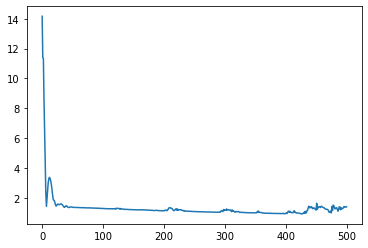

In [229]:
plt.plot(train_losses)

In [ ]:
# Sample from model
gen_history = history.clone()
model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

mask = torch.ones((1, 1), dtype=torch.bool)

hidden_states = None

# Move forward in time
wrong_cnt = 0
for t in range(1, max_length):
    #gen_history[t], hidden_states = model.forward_generate(gen_history[t - 1], instruments.squeeze(0), mask, num_inst, hidden_states)
    #if gen_history[t] != history[t]:
    #    wrong_cnt += 1
    gen_message, hidden_states = model.forward_generate(history[t - 1], instruments.squeeze(0), mask, num_inst, hidden_states)
    print(gen_message)
    if gen_message != history[t]:
        wrong_cnt += 1

print(wrong_cnt)

Get the model to overfit to a piece with two instruments

In [ ]:
recording = np.load('preprocessed_data/recording318.npy', allow_pickle=True)
instruments_np = np.load('preprocessed_data/instruments318.npy', allow_pickle=True)

max_length = 10
max_instruments = instruments_np.shape[0]
batch_size = 1

history = torch.zeros((max_length, max_instruments, 1), dtype=torch.long)
for i in range(max_instruments):
    history[:max_length, i, 0] = recording[i][:max_length]
    
instruments = torch.tensor([instrument_numbers.index(i) for i in instruments_np], dtype=torch.long).view(1, max_instruments, 1)
seq_lengths = torch.tensor(max_length).view(1, 1)
num_inst = [max_instruments]

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 501
train_losses = np.zeros(epochs)

for epoch in range(epochs):
    if epoch%100 == 0:
        print('Starting epoch %d' %(epoch))
    
    loss = model(history, instruments, seq_lengths, num_inst)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses[epoch] = loss.data
    
    if epoch%100 == 0:
        print('Loss: %f' %(loss.data))

# Custom dataset class

In [240]:
# Custom Dataset class
class MIDIDataset(torch.utils.data.Dataset):
    # CONSTRUCTOR: creates a list of recording files and a list
    # of instrument files in root_dir. Assumes that the directory
    # contains recording0.npy to recordingM.npy,
    # as well as instruments0.npy to instrumentsM.npy
    # ARGUMENTS
    # root_dir: the directory to search
    def __init__(self, root_dir, transform=None):
        files = os.listdir(root_dir)
        self.recordings = []
        self.instrument_files = []
        for file in files:
            if 'recording' in file:
                self.recordings.append(os.path.join(root_dir, file))
            elif 'instruments' in file:
                self.instrument_files.append(os.path.join(root_dir, file))
                
        assert(len(self.recordings) == len(self.instrument_files))
        self.recordings.sort()
        self.instrument_files.sort()
        self.transform = transform

    # __len__
    # RETURN: the number of recording files in the dataset
    def __len__(self):
        return len(self.recordings)

    # __getitem__
    # ARGUMENTS
    # idx: indicates which file to get
    # RETURN: an instance with keys 'instruments', 'history'
    # instance['history'] is a numpy array of message sequences for each instrument
    # instance['instruments'] a numpy array of instrument numbers
    def __getitem__(self, idx):
        instance = {'history': np.load(self.recordings[idx], allow_pickle=True), \
                    'instruments': np.load(self.instrument_files[idx], allow_pickle=True)}
        
        assert(len(instance['history']) == len(instance['instruments']))
        
        if self.transform:
            instance = self.transform(instance)
            
        return instance

In [245]:
# collate_fn: takes a list of samples from the dataset and turns them into a batch.
# ARGUMENTS
# batch: a list of dictionaries
# RETURN: a sample with keys 'history', 'instruments', and 'mask'
# sample['history']: an LxNxB tensor containing messages
# sample['instruments']: a 1xNxB tensor containing instrument numbers
# sample['seq_lengths']: an NxB tensor containing the length of each sequence
# sample['num_inst']: a length B tensor containing the number of instruments in each batch
def collate_fn(batch):
    batch_size = len(batch)
    
    # We size our tensors to accomodate the longest sequence and the largest ensemble
    max_instruments = max([len(instance['history']) for instance in batch])
    max_len = max([max([seq.shape[0] for seq in instance['history']]) for instance in batch])

    sample = {'history': torch.ones((max_len, max_instruments, batch_size), dtype=torch.long), \
              'instruments': torch.zeros((1, max_instruments, batch_size), dtype=torch.long), \
              'seq_lengths': torch.zeros((max_instruments, batch_size), dtype=torch.long), \
              'num_inst': torch.zeros(batch_size, dtype=torch.long)}

    for b in range(batch_size):
        instrument_idx = [instrument_numbers.index(inst) for inst in batch[b]['instruments']]
        sample['instruments'][0, :len(instrument_idx), b] = torch.tensor(instrument_idx, dtype=torch.long)
        sample['num_inst'][b] = len(instrument_idx)
        
        for inst_idx in range(len(batch[b]['history'])):
            seq_len = len(batch[b]['history'][inst_idx])
            sample['history'][:seq_len, inst_idx, b] = torch.tensor(batch[b]['history'][inst_idx], dtype=torch.long)
            sample['seq_lengths'][inst_idx, b] = seq_len
            
    return sample

# Train the model

In [248]:
hidden_size = 512
heads = 4
embed_dim = 256
grad_clip = 10
rlayers = 3

model = LinkedGRU(message_dim, embed_dim, num_instruments, hidden_size, heads, rlayers)

for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

In [ ]:
batch_size = 1
learning_rate = 0.001

dataset = MIDIDataset('preprocessed_data')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs) # TODO: train/test split

model.train()

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    for b, batch in enumerate(dataloader):
        print('Starting iteration %d' %(b))
        loss = model(batch['history'], batch['instruments'], batch['seq_lengths'], batch['num_inst'])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.data)
    
    torch.save(model.state_dict(), 'trained_models/epoch' + str(epoch) + '.pth')

Starting epoch 0
Starting iteration 0


# Sample from the model

In [5]:
model.load_state_dict(torch.load('trained_models/epoch4.pth'))

<All keys matched successfully>

In [ ]:
model.eval() # Disable dropout to make results repeatable

time_steps = 5000 # How many time steps do we sample?

max_instruments = 3

# Piano, violin, viola
instruments = torch.tensor([0, 2, 3]).view(1, max_instruments, 1)

# Suppose they all start with the same velocity message
# TODO: should we have SOS and EOS tokens like in NLP?
gen_history = 24*torch.ones((1, max_instruments, 1), dtype=torch.long)
mask = torch.zeros((1, 1, 1), dtype=torch.bool)

for t in range(1, time_steps):
    # Sanity check
    if t%100 == 0:
        print(t)
    next_messages = torch.zeros((1, max_instruments, 1), dtype=torch.long)
    for inst in range(max_instruments):
        logits = model(gen_history, mask.expand(t, max_instruments, -1), instruments, inst)
        probs = torch.nn.functional.softmax(logits[t - 1], dim=1)
        next_messages[0, inst, 0] = torch.multinomial(probs, 1)
    
    gen_history = torch.cat((gen_history, next_messages))

Save samples

In [15]:
gen_recording = np.array([0 for i in range(max_instruments)], dtype='object')
for i in range(max_instruments):
    gen_recording[i] = gen_history[:, i].flatten().numpy()
    
gen_instruments = np.array([instrument_numbers[instruments[0, i, 0].item()] for i in range(max_instruments)])
np.save('gen_recording.npy', gen_recording)
np.save('gen_instruments.npy', gen_instruments)